In [ ]:
!git clone https://github.com/YusrilHasanuddin/BatikGAN.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir dataset
!mkdir model
!mkdir dataset/Real-Image
!mkdir dataset/Patch
!mv BatikGAN/dataset_batik/Patch/* dataset/Patch
!mv BatikGAN/dataset_batik/Real-Image/* dataset/Real-Image
!ls dataset/Real-Image
!ls dataset/Patch

# **Import Library**

In [ ]:
%load_ext tensorboard

import os
import cv2
import time
import keras
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from itertools import product
from scipy.linalg import sqrtm
from skimage.transform import resize
from keras.preprocessing import image
from keras.models import Input, Model
from keras.initializers import RandomNormal
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.layers import Layer, LeakyReLU, Conv2D, Conv2DTranspose, Concatenate, Activation

In [ ]:
base_dir = '/content/dataset'
model_dir = '/cotent/model'

# **Prepare Dataset**

In [ ]:
class DataPipeline:
    def __init__(self):
        # self.path = path
        self

    def load_data(self, path, size):
        list_img = list()
        for filename in os.listdir(path):
                # load and resize the image
            img = image.load_img(path + filename, target_size=size)
            # convert to numpy array
            img = image.img_to_array(img)
            # Convert to lower case
            path_file = (path + filename).lower()
            # store
            list_img.append([path_file, img])
        img_sorted = sorted(list_img)
        img_arr = np.asarray([i[1] for i in img_sorted])

        return img_arr

    def concat_image(self, patch_a, patch_b):
        def h(patch_a, patch_b):
            h = tf.concat([patch_a, patch_b, patch_a, patch_b], 1)
            return h
        v = tf.concat([h(patch_a, patch_b), h(patch_b, patch_a), 
                       h(patch_a, patch_b), h(patch_b, patch_a)], 2)
        return v

    def normalisasi(self, A, B):
        A = tf.cast(A, dtype=tf.float32)
        A = (A-127.5)/127.5
        B = tf.cast(B, dtype=tf.float32)
        B = (B-127.5)/127.5
        img = self.concat_image(tf.expand_dims(A, axis=0), 
                                tf.expand_dims(B, axis=0))[0]
        return A, B, img

    def execute(self):
        # dataset = self.load_data()
        path = '/content/dataset_batik/'
        data_patch = self.load_data(path + 'Patch/', (32, 32))

        patch_a = data_patch[[i for i in range(326) if i % 2 == 0]]
        patch_b = data_patch[[i for i in range(326) if i % 2 != 0]]

        dataset = tf.data.Dataset.from_tensor_slices((patch_a, patch_b))

        # # AUTOTUNE = tf.data.experimental.AUTOTUNE
        dataset = dataset.map(self.normalisasi, num_parallel_calls=-1).cache().map(
                  lambda A, B, real: (tf.image.random_flip_left_right(A), tf.image.random_flip_left_right(B),
                                      tf.image.random_flip_left_right(real))
                ).map(
                    lambda A, B, real: (tf.image.random_flip_up_down(A), tf.image.random_flip_up_down(B),
                                        tf.image.random_flip_up_down(real))   
                )
        dataset = dataset.batch(1, drop_remainder=True).repeat(2)
        dataset = dataset.prefetch(1)
        return dataset

In [ ]:
dataset = DataPipeline().execute()

In [ ]:
dataset

<PrefetchDataset shapes: ((1, 32, 32, 3), (1, 32, 32, 3), (1, 128, 128, 3)), types: (tf.float32, tf.float32, tf.float32)>

# **Building Block Layer**

In [ ]:
# Convolution
def ConvLayer(input, filter, kernel, strides=2, padding='same'):
    X = Conv2D(filter, kernel, strides=strides, padding=padding, 
               use_bias=False)(input)
    X = LeakyReLU()(X)
    return X

In [ ]:
# Deconvolution
def DeconvLayer(input, filter, kernel, strides=2, padding='same'):
    X = Conv2DTranspose(filter, kernel, strides=strides, 
                        padding=padding, use_bias=False)(input)
    X = LeakyReLU()(X)
    return X

In [ ]:
# Resiudal
def ResidualBlock(input, filter, kernel, strides=1, padding='same'):
    # Layer 1
    X = Conv2D(filter, kernel, strides=strides, padding=padding, 
               use_bias=False)(input)
    X = LeakyReLU()(X)

    # Layer 2
    X = Conv2D(filter, kernel, strides=strides, padding=padding, 
                        use_bias=False)(X)

    # ADD
    X = tf.keras.layers.Add()([X, input])  
    return X

# **Generator**

In [ ]:
def define_generator(input_layer, n_residual=6, ks=3):
    g = ConvLayer(input_layer, 64, ks, strides=1)
    g = ConvLayer(g, 128, ks)
    g = ConvLayer(g, 256, ks)

    for _ in range(n_residual):
        g = ResidualBlock(g, 256, 3, strides=1)

    g = DeconvLayer(g, 256, ks, strides=1)
    g = DeconvLayer(g, 128, ks)
    g = DeconvLayer(g, 64, ks)
    g = DeconvLayer(g, 32, ks)
    g = DeconvLayer(g, 16, ks)
    g = DeconvLayer(g, 32, ks, strides=1)

    return g

In [ ]:
def fusion_generator(image_shape=(32,32,3), ks=(3,3)):
    patchA = Input(shape=image_shape)
    FA = define_generator(patchA)
    
    patchB = Input(shape=image_shape)
    FB = define_generator(patchB)

    FAB = Concatenate(axis=3)([FA, FB])

    g = ConvLayer(FAB, 32, ks, strides=1)
    g = ConvLayer(g, 16, ks, strides=1)
    IBatik = Conv2D(3, ks, padding='same')(g)
    IBatik = Activation('tanh')(IBatik)
    
    model = Model([patchA, patchB], IBatik)
    return model

In [ ]:
fusion_generator().summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_463 (Conv2D)             (None, 32, 32, 64)   1728        input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_478 (Conv2D)             (None, 32, 32, 64)   1728        input_14[0][0]                   
____________________________________________________________________________________________

# **Discriminator**

In [ ]:
def define_discriminator(image_shape=(128,128,3)):
    in_image = Input(shape=image_shape)
    d = ConvLayer(in_image, 32, 2)
    d = ConvLayer(d, 64, 2)
    d = ConvLayer(d, 128, 2)
    d = ConvLayer(d, 256, 2)
    d = ConvLayer(d, 512, 2, strides=1)
    d = ConvLayer(d, 512, 2, strides=1, padding='valid')

    d = Conv2D(1, (2,2), strides=(1,1))(d)
    d = Activation('sigmoid')(d)
    model = Model(in_image, d)
    return model

In [ ]:
define_discriminator().summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_496 (Conv2D)          (None, 64, 64, 32)        384       
_________________________________________________________________
leaky_re_lu_114 (LeakyReLU)  (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_497 (Conv2D)          (None, 32, 32, 64)        8192      
_________________________________________________________________
leaky_re_lu_115 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_498 (Conv2D)          (None, 16, 16, 128)       32768     
_________________________________________________________________
leaky_re_lu_116 (LeakyReLU)  (None, 16, 16, 128)       0   

# **Create Model**

In [ ]:
class BatikGenerator(keras.Model):
    def __init__(
        self,
        local_discriminator,
        discriminator,
        generator,
        weight_loss
    ):
        super(BatikGenerator, self).__init__()
        self.local_discriminator = local_discriminator
        self.discriminator = discriminator
        self.generator = generator
        self.weight_loss = weight_loss

    def compile(self, d_local_optimizer, d_optimizer, g_optimizer, d_loss_fn, 
                g_loss_fn, local_l2_loss_fn, style_loss):
        super(BatikGenerator, self).compile()
        self.d_local_optimizer = d_local_optimizer # Optimizer D Local
        self.d_optimizer = d_optimizer # Optimizer D Global
        self.g_optimizer = g_optimizer # Optimizer G
        self.d_loss_fn = d_loss_fn # Adversarial Loss Function
        self.g_loss_fn = g_loss_fn # GAN Loss Function
        self.local_l2_loss_fn = local_l2_loss_fn # Local L2 Function
        self.style_loss = style_loss # Style Loss Function

    def extract_patches(self, img, size=32):
        list_img = []
        for r in range(0, img.shape[0], size):
            for c in range(0, img.shape[1], size):
                r = r - (r+size - img.shape[0]) if r+size > img.shape[0] else r
                c = c - (c+size - img.shape[0]) if c+size > img.shape[1] else c
                list_img.append(img[r:r+size, c:c+size,:])
        return tf.convert_to_tensor(list_img)
    
    def train_step(self, batch_data):
        patchA, patchB, real_images = batch_data
        batch_size = tf.shape(real_images)[0]

        ############ TRAIN DISCRIMINATOR ###############
        with tf.GradientTape(persistent=True) as tape:
            generated_images = self.generator([patchA, patchB], training=False)

            fake_logits = self.discriminator(generated_images, training=True)
            real_logits = self.discriminator(real_images, training=True)

            ######## Train Discriminator Global ##########
            d_loss = self.weight_loss['adversarial'] * self.d_loss_fn(real_img=real_logits, fake_img=fake_logits, type_loss='GLOBAL')

            ######## Extract patch Image ##########
            patch_real = self.extract_patches(real_images[0], size=48)
            patch_fake = self.extract_patches(generated_images[0], size=48)

            fake_logits_local = self.local_discriminator(patch_fake, training=True)
            real_logits_local = self.local_discriminator(patch_real, training=True)

            ######## Train Discriminator Local ##########
            total_local_loss = self.weight_loss['adversarial_local'] * \
                                (self.d_loss_fn(real_img=real_logits_local, 
                                                    fake_img=fake_logits_local, 
                                                    type_loss='LOCAL') - 1)**2
        
        d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(
            zip(d_gradient, self.discriminator.trainable_variables)
        )
        local_d_gradient = tape.gradient(total_local_loss, self.local_discriminator.trainable_variables)
        self.d_local_optimizer.apply_gradients(
            zip(local_d_gradient, self.local_discriminator.trainable_variables)
        )

        ############# TRAIN GENERATOR ##############
        with tf.GradientTape(persistent=True) as tape:
            generated_images = self.generator([patchA, patchB], training=True)
            fake_logits = self.discriminator(generated_images, training=False) 

            local_l2 = self.weight_loss['local_l2'] * self.local_l2_loss_fn(patchA, patchB, generated_images) # Recontruction Loss

            ######## Extract patch Image ##########
            patch_fake = self.extract_patches(generated_images[0], size=48)
            patch_real = self.extract_patches(real_images[0], size=48)

            ######## GAN LOSS ############
            fake_logits_local = self.local_discriminator(patch_fake, training=False)
            gen_local_loss = self.g_loss_fn(fake_logits_local, 'LOCAL')
            
            ########### Stye loss ###########
            style_loss = self.style_loss(generated_images, real_images, self.weight_loss['style_loss']) 

            ########### Local Style Loss ###########
            loc_style_loss = self.style_loss(patch_fake, patch_real, self.weight_loss['local_style_loss'])
            
            ########### Total Generator Loss ###########
            g_loss = local_l2 + self.g_loss_fn(fake_logits, 'GLOBAL') + \
                    style_loss + gen_local_loss + loc_style_loss

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss, 'style_loss': style_loss, 
                'local_style_loss':loc_style_loss, 'd_local_loss':total_local_loss}

# **Create a Keras callback that periodically saves generated images**

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=1):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        sequence = [i for i in range(163)]
        _patchA = list([img[0] for img in list(dataset.as_numpy_iterator())])[0] #[random.choice(sequence)]
        _patchB = list([img[1] for img in list(dataset.as_numpy_iterator())])[0] #[random.choice(sequence)]
        generated_images = self.model.generator([_patchA, 
                                                 _patchB])

        if (epoch+1)%20==0:
          _, ax = plt.subplots(1, 3, figsize=(10, 10))
          ax[0].imshow((_patchA[0]+1)/2)
          ax[1].imshow((_patchB[0]+1)/2)
          ax[2].imshow((generated_images[0]+1)/2)
          ax[0].set_title("Input image A")
          ax[1].set_title("Input image B")
          ax[2].set_title("Translated image")
          ax[0].axis("off")
          ax[1].axis("off")
          ax[2].axis("off")

          plt.show()

# **Definition Function Loss**

In [ ]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
style_weights = {'block1_conv1': 0.244,
                 'block2_conv1': 0.061,
                 'block3_conv1': 0.015,
                 'block4_conv1': 0.004,
                 'block5_conv1': 0.004}

num_style_layers = len(style_layers)

class AdditionalFunction:
    def __init__(self):
        pass

    def vgg_layers(self, layer_names):
        # Load our model. Load pretrained VGG, trained on imagenet data
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        vgg.trainable = False

        outputs = [vgg.get_layer(name).output for name in layer_names]

        model = tf.keras.Model([vgg.input], outputs)
        return model

    def gram_matrix(self, input_tensor):
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
        return result/(num_locations)

    def style_compute(self, input_img):
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(
            input_img)
        outputs = self.vgg_style(preprocessed_input)
        
        style_outputs = [self.gram_matrix(style_output)
                        for style_output in outputs]

        style_dict = {style_name:value
                      for style_name, value
                      in zip(style_layers, style_outputs)}
        return style_dict
    
class LossFunction(AdditionalFunction):
    def __init__(self):
        super().__init__()
        self.vgg_style =  self.vgg_layers(style_layers)
        self.vgg_style.trainable = False

        # self.mse = tf.keras.losses.MeanSquaredError()
        # self.style_layers = style_layers
        # self.num_style_layers = len(style_layers)

    ######## Style Loss ###########
    def style_loss(self, gen_image, real_image, style_weight):
        style_outputs = self.style_compute(gen_image)
        style_targets = self.style_compute(real_image)

        style_loss = tf.add_n([tf.reduce_mean(tf.abs(
            style_outputs[name]-style_targets[name])) * style_weights[name]
            for name in style_outputs.keys()])
        style_loss *= style_weight / num_style_layers

        return style_loss

    ################ EXTRACT PATCH ###############
    def extract_patches(self, img, size=32):
        list_img = []
        for r in range(0, img.shape[0], size):
            for c in range(0, img.shape[1], size):
                list_img.append(img[r:r+size, c:c+size,:])
        img_arr =  np.array([img for img in list_img if img.shape==(size,size,3)])
        return img_arr


    ############ L2 Loss / Recontruction Loss ############
    def local_l2_loss(self, patchA, patchB, batik_gen_fake):
        blockY = [1, 3, 6, 8, 9, 11, 14, 16]
        blockZ = [2, 4, 5, 7, 10, 12, 13, 15]

        img_patch = self.extract_patches(batik_gen_fake[0], size=32)
        dict_img_patch = dict(enumerate(img_patch, 1))
        
        tempA = tf.norm([patchA[0] - dict_img_patch.get(key) for key in blockY])
        tempB = tf.norm([patchB[0] - dict_img_patch.get(key) for key in blockZ])
        temp = tempA + tempB

        return temp

    ######### D LOSS ##############
    def discriminator_loss(self, real_img, fake_img, type_loss, 
                           label_smoothing=0.25):
        real_loss = tf.keras.losses.binary_crossentropy(
            tf.ones_like(real_img), 
            real_img, 
            from_logits=True, 
            label_smoothing=label_smoothing)
        generated_loss = tf.keras.losses.binary_crossentropy(
            tf.zeros_like(fake_img), 
            fake_img, from_logits=True, 
            label_smoothing=label_smoothing)
        loss = real_loss + generated_loss
        return loss

    ######### G LOSS ##############
    def generator_loss(self, fake_img, type_loss):
        label_smoothing = 0.25
        loss = tf.keras.losses.binary_crossentropy(
            tf.ones_like(fake_img), 
            fake_img, 
            from_logits=True, 
            label_smoothing=label_smoothing)
        return loss

# **Main Class**

In [ ]:
class Main:
    def __init__(self, dataset):
        self.optD_local = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.5)
        self.optD = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.5)
        self.optG = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.5)
        self.loss_func = LossFunction()
        self.gen = fusion_generator()
        self.disc = define_discriminator()
        self.local_disc = define_discriminator((48,48,3))
        self.root_dir = model_dir
        self.dataset = dataset

    def __model__(self, weight_loss=None):
        # Instantiate the model.
        model = BatikGenerator(
            local_discriminator=self.local_disc,
            discriminator=self.disc,
            generator=self.gen,
            weight_loss = weight_loss
        )

        # Compile the model.
        model.compile(
            d_local_optimizer = self.optD_local,
            d_optimizer = self.optD,
            g_optimizer = self.optG,
            g_loss_fn = self.loss_func.generator_loss,
            d_loss_fn = self.loss_func.discriminator_loss,
            local_l2_loss_fn = self.loss_func.local_l2_loss,
            style_loss = self.loss_func.style_loss,
        )

        return model
    
    def load_model(self, version, weight_loss=None):
        model = self.__model__(weight_loss)
        model.load_weights('{}BatikGAN_SL/{}/model.cpkt'.format(self.root_dir, version)).expect_partial()
        return model

    def train_model(self, epoch, version, weight_loss, initial_epoch=0, 
                    save_model=False, continue_train=False, save_plot=False):
        # Instantiate the customer `Monitor` Keras callback.
        cbk = GANMonitor(num_img=1)

        if continue_train==True:
            model = self.load_model(version, weight_loss)
        else:
            model = self.__model__(weight_loss)

        # Start training the model.
        start_time = time.time()
        if save_plot == True:
            _log_dir = "{}BatikGAN_SL/{}/logs/fit".format(self.root_dir, version)
            tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=_log_dir, histogram_freq=1)
            model.fit(self.dataset, epochs=epoch, initial_epoch=initial_epoch, callbacks=[cbk, tensorboard_callback])
        elif save_plot == False:
            model.fit(self.dataset, epochs=epoch, initial_epoch=initial_epoch, callbacks=[cbk])

        time_need = (time.time() - start_time)
        print("--- {} seconds ---".format(time_need))

        if save_model==True:
            model.save_weights("{}BatikGAN_SL/{}/model.cpkt".format(self.root_dir, version))
            if os.path.exists("{}BatikGAN_SL/{}/time.txt".format(self.root_dir, version)):
                file1 = open("{}BatikGAN_SL/{}/time.txt".format(self.root_dir, version),"r") 
                temp = file1.read()
                file1 = open("{}BatikGAN_SL/{}/time.txt".format(self.root_dir, version),"w") 
                file1.write(str(time_need + float(temp)))
                file1.close()
            else:
                file1 = open("{}BatikGAN_SL/{}/time.txt".format(self.root_dir, version),"w") 
                file1.write(str(time_need))
                file1.close()  
        return model

main = Main(dataset)

# **Train Model**

In [ ]:
EPOCH = 1000
VERSION = "Replikasi"
WEIGHT_LOSS = {'adversarial':1, 
               'local_l2':1, 
               'style_loss':10, 
               'adversarial_local':100, 
               'local_style_loss':1,}

model = main.train_model(EPOCH, VERSION, WEIGHT_LOSS, initial_epoch=0,
                         save_model=False, continue_train=False, save_plot=False)

# **Plotting**

In [ ]:
%tensorboard --logdir {base_dir}/4.\ Code/Model/BatikGAN_SL/Replikasi/logs/fit

# **Testing and Evalution**

In [ ]:
class Evaluation:
    def __init__(self, dataset, model):
        self.root_dir='/content/drive/MyDrive/Tugas Akhir/4.Code/Model/'
        self.inception_model = InceptionV3(include_top=False, pooling='avg')
        self.dataset = dataset
        self.model = model

    def generate_images(self, id_A, id_B, plot=0, save_to_dir=False, version_name=None):
        n_cols = 3
        nrows = len(id_A)

        patchA = tf.convert_to_tensor([list(self.dataset.as_numpy_iterator())[id][0][0] for id in id_A])
        patchB = tf.convert_to_tensor([list(self.dataset.as_numpy_iterator())[id][1][0] for id in id_B])
        generated_images = self.model.generator([patchA, 
                                                 patchB])

        if save_to_dir==True:
            if os.path.exists('{}BatikGAN_SL/{}/Generate Images'.format(self.root_dir, version_name))==False:
                os.mkdir('{}BatikGAN_SL/{}/Generate Images'.format(self.root_dir, version_name))
            
            for id, img in enumerate(generated_images):
                prediction = keras.preprocessing.image.array_to_img(img)
                prediction.save(
                    "{}BatikGAN_SL/{}/Generate Images/Batik_{}.png".format(self.root_dir, version_name, id+1)
                )  
       
        if plot>0:
            img_to_plot = [img for _, img_tup in enumerate(
                zip(patchA[:plot], patchB[:plot], generated_images[:plot])) for _, img in enumerate(
                    zip(img_tup, ('Patch A', 'Patch B', 'Result')))]
            fig = plt.gcf()
            fig.set_size_inches(n_cols * 3, nrows * 3)

            for i, (img, title) in enumerate(img_to_plot):
                sp = plt.subplot(nrows, n_cols, i + 1)
                sp.axis('Off')

                plt.title(title)
                plt.imshow((img+1)/2)

            plt.show()
        return generated_images.numpy()

    # calculate frechet inception distance
    def calculate_fid(self, images1, images2):
        # # calculate activations
        act1 = self.inception_model.predict(images1)
        act2 = self.inception_model.predict(images2)
        # calculate mean and covariance statistics
        mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
        mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = np.sum((mu1 - mu2)**2.0)
        # calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

    def scale_images(self, images, new_shape):
        images_list = list()
        for image in images:
            # resize with nearest neighbor interpolation
            new_image = resize(image, new_shape, 0)
            # store
            images_list.append(new_image)
        return np.asarray(images_list)

    def split_img(self, imgs, size=32):
        list_img = []
        for img in imgs:
            for r in range(0, img.shape[0], size):
                for c in range(0, img.shape[1], size):
                    list_img.append(img[r:r+size, c:c+size,:])
        img_arr =  np.array([img for img in list_img if img.shape==(size,size,3)])
        return img_arr
    
    def fid_local(self, id_A, id_B, batik_generate):
        patchA = np.array([img[0][0] for index, img in enumerate(list(self.dataset.as_numpy_iterator()))]) # Patch A
        patchB = np.array([img[1][0] for index, img in enumerate(list(self.dataset.as_numpy_iterator()))]) # Patch B
        patchA_select = np.array([patchA[index] for index in id_A]) # Real Batik Select from ID
        patchB_select = np.array([patchB[index] for index in id_B]) # Real Batik Select from ID
        
        patch = np.concatenate([patchA_select, patchB_select], axis=0)
        img_gen = self.split_img(batik_generate)

        img_gen = self.scale_images(img_gen, (299,299,3))
        patch = self.scale_images(patch, (299,299,3))

        # pre-process images
        img_gen = preprocess_input(img_gen)
        patch = preprocess_input(patch)

        fid = self.calculate_fid(img_gen, patch)
        return fid

    def fid_global(self, id_A, id_B, batik_generate):
        real = np.array([img[2][0] for index, img in enumerate(list(self.dataset.as_numpy_iterator()))]) # Real Batik
        ID = list(dict.fromkeys(ID_A + ID_B)) # ID Select
        real_select = np.array([real[index] for index in ID]) # Real Batik Select from ID

        batik_generate = self.scale_images(batik_generate, (299,299,3))
        real_select = self.scale_images(real_select, (299,299,3))

        # pre-process images
        batik_generate = preprocess_input(batik_generate)
        real_select = preprocess_input(real_select)
        
        # calculate fid
        fid = self.calculate_fid(batik_generate, real_select)
        return fid

    def fid(self, id_A, id_B, batik_generate):
        fid_global = self.fid_global(id_A, id_B, batik_generate)
        fid_local = self.fid_local(id_A, id_B, batik_generate)
        print('FID Global: %.3f' % fid_global)
        print('FID Local: %.3f' % fid_local)

In [ ]:
sequence = [i for i in range(163)]
ID_A = [random.choice(sequence) for _ in range(4)]
ID_B = [random.choice(sequence) for _ in range(4)]

In [ ]:
print(ID_A)
print(ID_B)

[46, 147, 24, 29]
[95, 28, 118, 53]


In [ ]:
model1 = main.load_model(version='Replikasi')
model2 = main.load_model(version='ReplikasiNoAugmentation')

In [ ]:
evaluation1 = Evaluation(dataset, model1)
evaluation2 = Evaluation(dataset, model2)

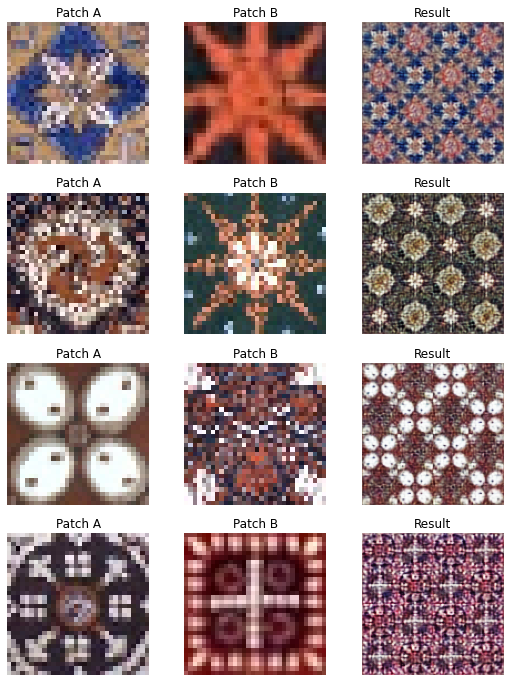

In [ ]:
result1 = evaluation1.generate_images(ID_A, ID_B, plot=10, save_to_dir=False, 
                                    version_name='Replikasi')

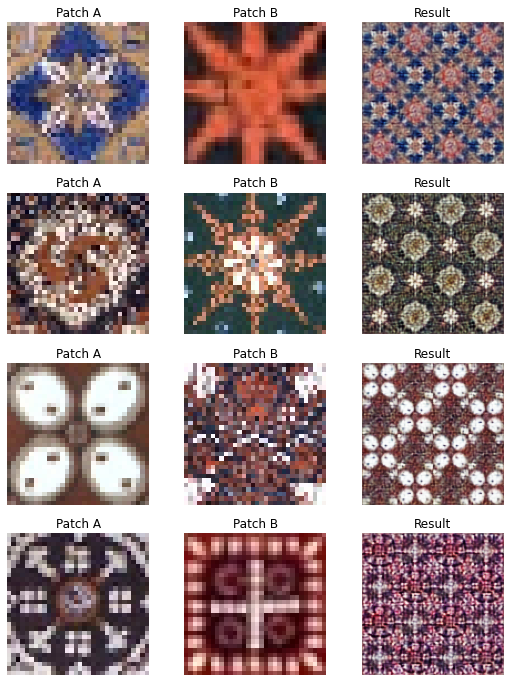

In [ ]:
result2 = evaluation2.generate_images(ID_A, ID_B, plot=10, save_to_dir=False, 
                                    version_name='ReplikasiNoAugmentation')

In [ ]:
evaluation1.fid(ID_A, ID_B, result1)

FID Global: 41.409
FID Local: 28.236


In [ ]:
evaluation2.fid(ID_A, ID_B, result2)

FID Global: 43.430
FID Local: 29.985
